In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# All the flows
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

import bayesflow as bf

2024-04-25 18:37:31.321844: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 18:37:31.368365: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 18:37:31.575363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 18:37:31.575405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 18:37:31.612715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [12]:
# Constants
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [2]:
#Read in the data
dataset = pd.read_csv('../data/full_data.csv', delimiter=";")
dataset.shape

(217132, 17)

In [3]:
# Inspecting the data
dataset.head(5)

,Timestamp,Lap_Number,Position.x.,Position.y.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate_Ang,Ang_Pos
0,1688764397665,0,-255.4,347.4990,-181.9740,0.000000e+00,-270.755071,351.018900,-138.681686,1,1157.191,434.2069,0.000000e+00,1.333622e-07,1,-22.572101,202.572101
1,1688764397682,0,-255.4,347.5181,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-22.572101,202.572101
2,1688764397699,0,-255.4,347.5356,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-22.572101,202.572101
3,1688764397715,0,-255.4,347.5516,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-22.572101,202.572101
4,1688764397732,0,-255.4,347.5663,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-22.572101,202.572101


In [4]:
# Determine the number of subjects
subjects = np.unique(dataset['Subject'].to_numpy())
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [5]:
subject_1_data = dataset[dataset['Subject'] == 3]
subject_1_data.shape

(13992, 17)

## Data exploration: hierarchical structure

/tmp/ipykernel_628/2641721805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['Gaze.x.'] = gaze_data['Gaze.x.'] / DISPLAY_X - 0.5
/tmp/ipykernel_628/2641721805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_data['Gaze.y.'] = gaze_data['Gaze.y.'] / DISPLAY_Y - 0.5
/tmp/ipykernel_628/2641721805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

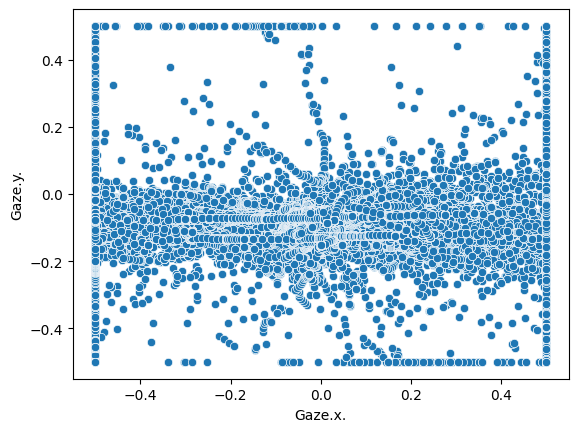

In [22]:
gaze_data = dataset[['Gaze.x.', 'Gaze.y.', 'Ang_Pos', 'Subject']]
gaze_data['Gaze.x.'] = gaze_data['Gaze.x.'] / DISPLAY_X - 0.5
gaze_data['Gaze.y.'] = gaze_data['Gaze.y.'] / DISPLAY_Y - 0.5
gaze_data['Ang_Pos'] = (gaze_data['Ang_Pos'] / 360 - 0.5) * np.pi 

sns.scatterplot(x=gaze_data['Gaze.x.'], y=gaze_data['Gaze.y.'])

<Axes: xlabel='Gaze.x.', ylabel='Count'>

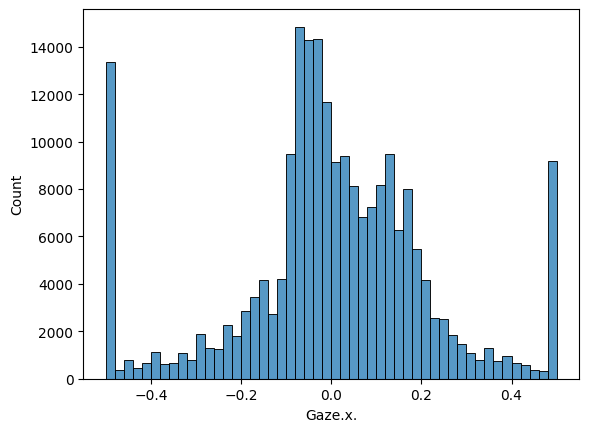

In [15]:
sns.histplot(gaze_data['Gaze.x.'], bins=50)

In [24]:
def plot_gaze_by_axis(param, bins=50):
    f, axs = plt.subplots(4, 4, figsize=(14, 10))

    for i in range(len(subjects)):
        j, k = int(np.floor(i/4)), i%4
        subject_data = gaze_data[gaze_data['Subject'] == (i + 1)]
        subject_gaze = subject_data[param].to_numpy()
        sns.histplot(subject_gaze, bins=bins, ax=axs[j, k], color="maroon")
        axs[j, k].set_title('Subject {id}'.format(id = i + 1))
        axs[j, k].set_xlabel(param)

    axs.flat[len(subjects)] = sns.histplot(gaze_data[param].to_numpy(), bins=bins, color="purple")
    axs.flat[len(subjects)].set_title('All Subjects')
    axs.flat[len(subjects)].set_xlabel(param)
    plt.tight_layout()

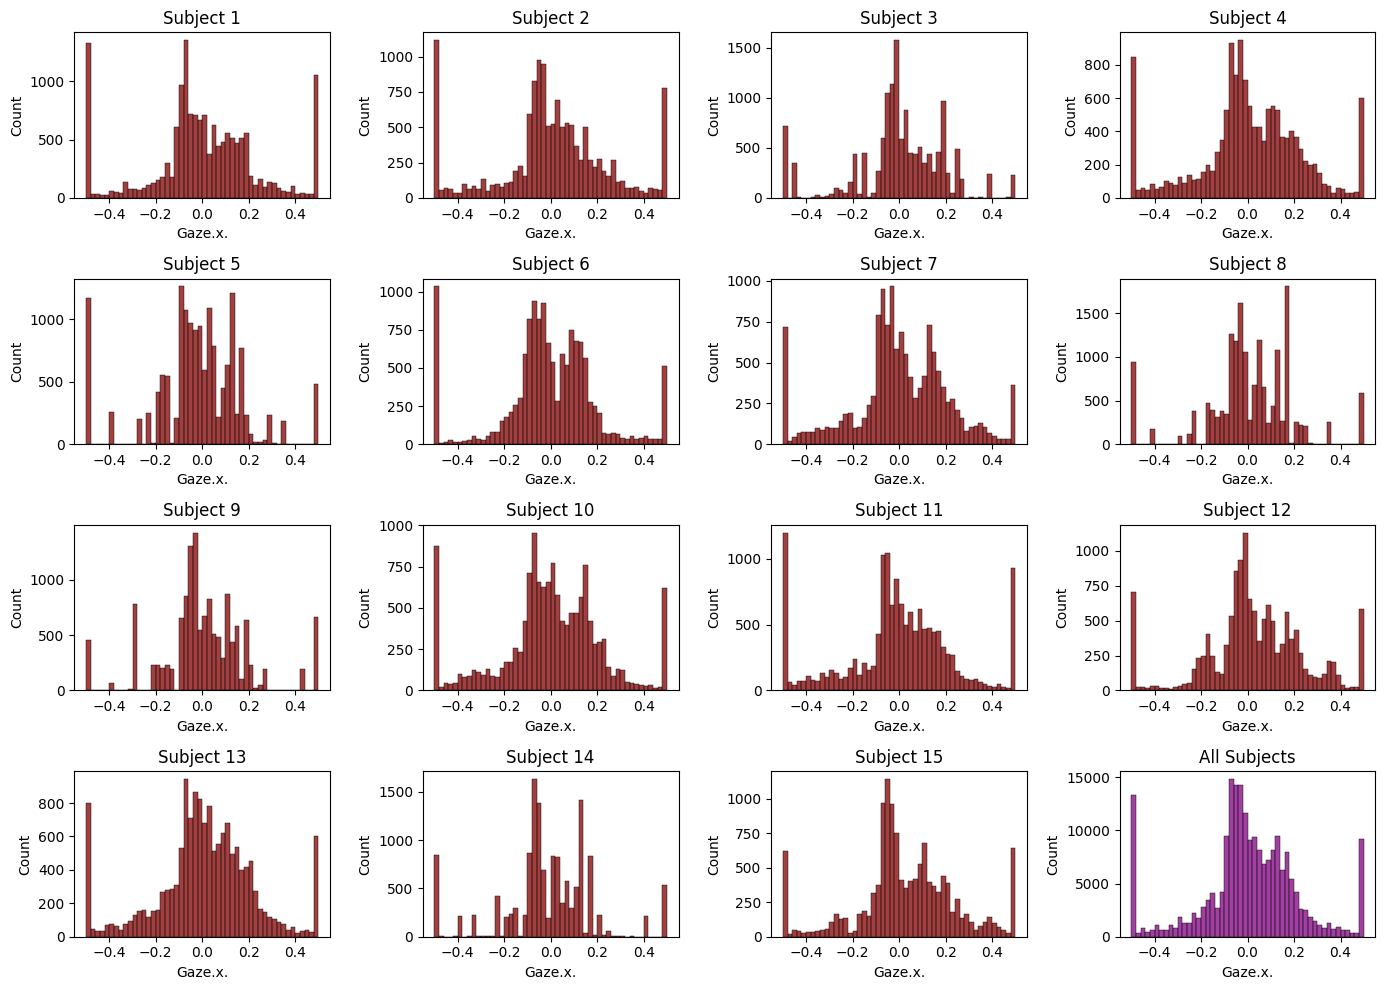

In [29]:
plot_gaze_by_axis('Gaze.x.', bins=50)

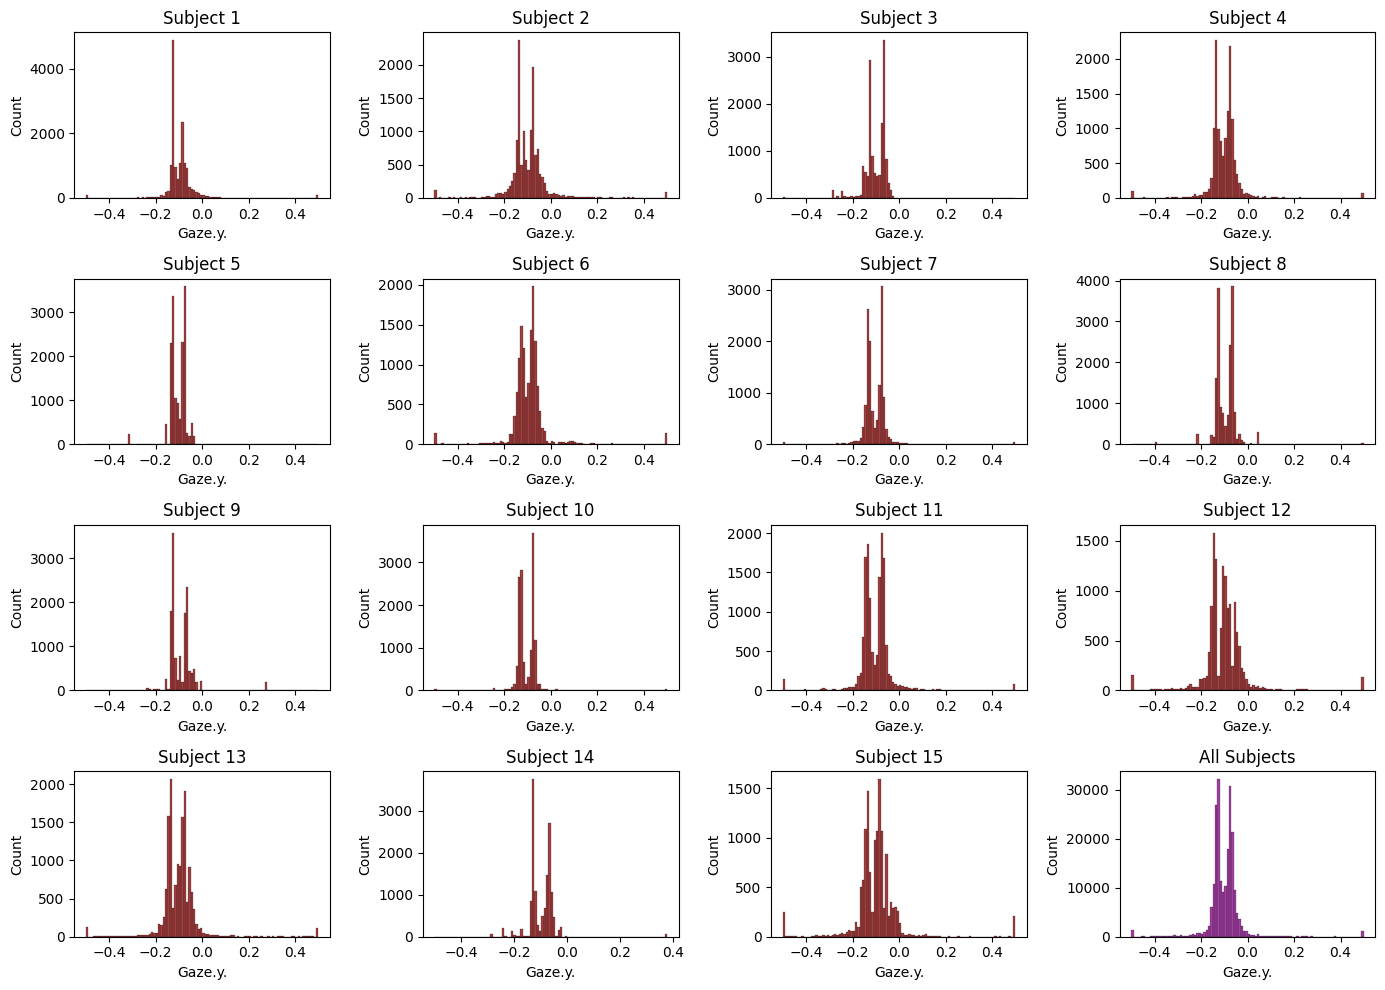

In [30]:
plot_gaze_by_axis('Gaze.y.', bins=100)

Interestingly, the gaze data from both x- and y-axis exhibits the mixture-distributed characteristics.

In [ ]:
def gaze_simulator_test():
    pass

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z.
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate_Ang (Gate orientation in world coordinates)
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

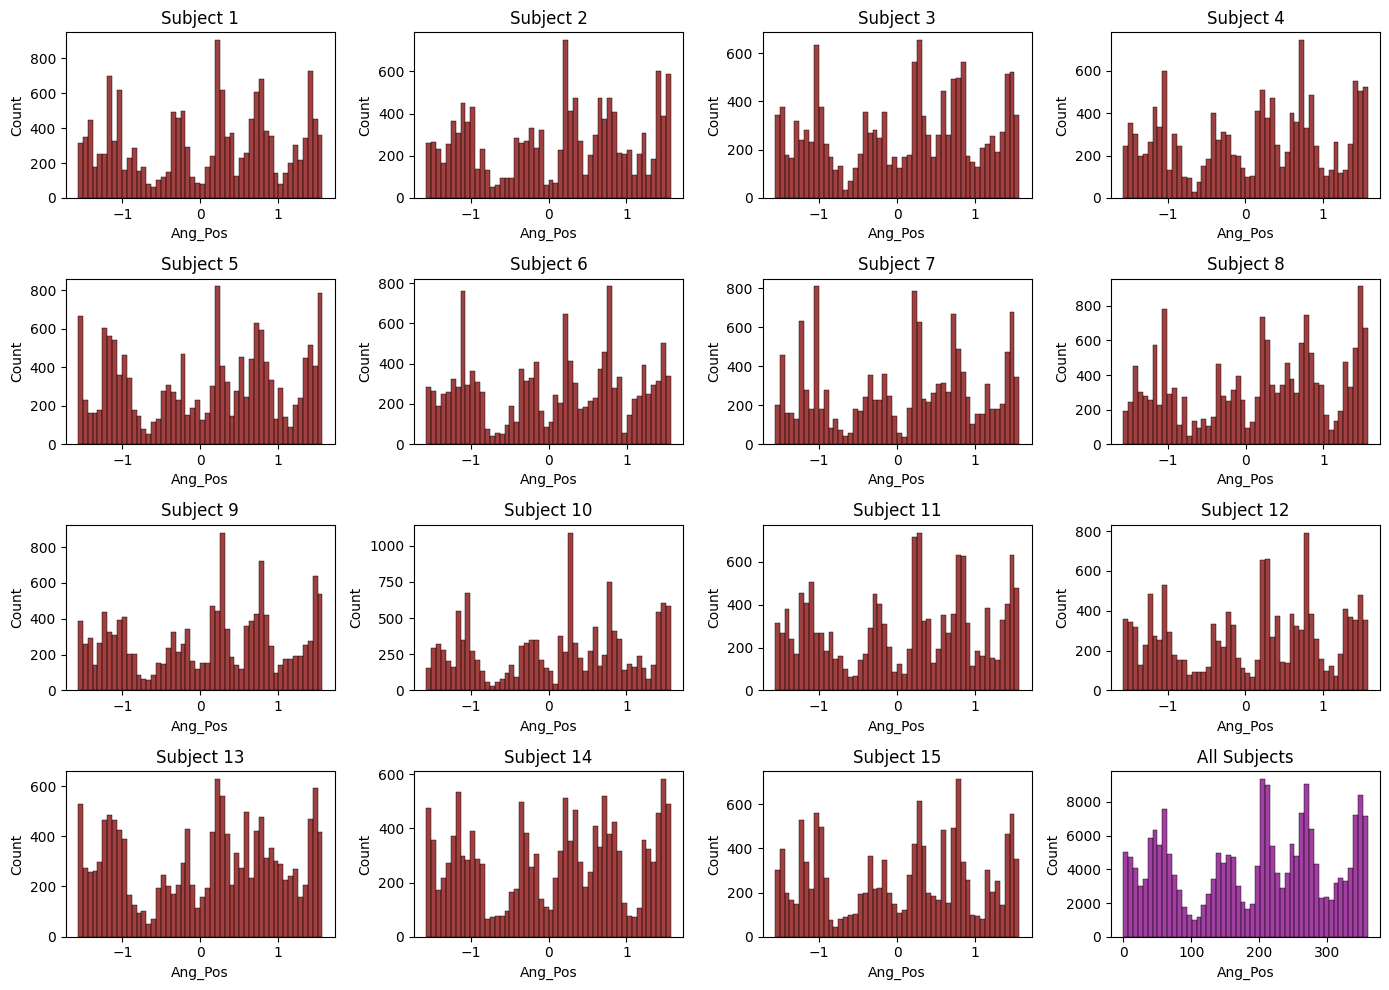

In [23]:
plot_gaze_by_axis('Ang_Pos')

In [11]:
#Normalize (x,y) to 0-1
gaze_x = dataset['Gaze.x.'] / 2560
gaze_y = dataset['Gaze.y.'] / 1080

gaze_x.max(), gaze_y.max()